imports

In [1]:
#Import ximea (camera software)
import sys
sys.path.append('C:/XIMEA/API/Python/v3')
import ximea
from ximea import xiapi

#import useful things
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy
import scipy.optimize
import pandas as pd

# Import HS classes assuming they reside one directory above
hspath = os.path.abspath('..')
if hspath not in sys.path:
    sys.path.append(hspath)
from HS_Image import *
from HWS.HS_Centroids import *
from HWS.HS_Gradients import *
from HWS.HS_WFP import *
import HWS.HSM_WFN as HSM_WFN


In [2]:
#name of folder where the centroids are saved
folder_name = 'background_28_08'

HWS values

In [3]:
# number of centroid sets
N = 2000
M = int(N/2)
# file path to save to, load from
file_path = os.getcwd()
# size of image taken by HWS (pixels)
img_size = 2048
# distance from CCD array to Heartmann plate
lever_arm = 8.73e-3 # (m)
# magnification due to imaging telescope (measured)
magnification = 1/0.509
# pixel size in CCD array
pixel_size = 5.5e-6
# wavelength of SLD light (m)
wavelength = 830e-9
# distance between holes on the Heartmann plate
hole_spacing = 4e-4 # (m)
# origin
origin = 2047/2

load centroids

In [4]:
# determine the number of centroids in each set 
test_cents =  np.load(os.path.join(file_path, os.path.join(folder_name, f'centroids0.npy')))
no_cents = np.shape(test_cents)[0]
print('number of centroids =', no_cents)

number of centroids = 699


In [5]:
centroids = np.zeros((N, no_cents, 2))
for i in range(N):
    centroids[i] = np.load(os.path.join(file_path, os.path.join(folder_name, f'centroids{i}.npy')))

data images are those from 500 to 1500
reference images are those from 0 to 500 and those from 1500 to 2000


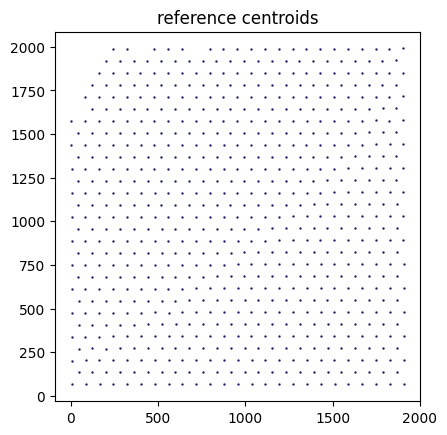

In [6]:
# assign which cents will be used as reference and which will be used as the data or reference cents
a = int(N/4)
b = int(3*N/4)
print('data images are those from', a, 'to', b)
print('reference images are those from 0 to', a, 'and those from', b, 'to', N)

reference_centroids = [*centroids[0:a], *centroids[b:N]]
data_centroids = centroids[a:b]

sum = np.zeros((no_cents, 2))
for i in range(M):
    sum += reference_centroids[i]
reference = sum/(M)

plt.scatter(reference[:,0], reference[:,1], color = 'midnightblue', s = 0.5)
plt.gca().set_aspect('equal')
plt.title('reference centroids')
plt.show()

functions

In [7]:
def error_in_centroids(M, average_gradients):
    '''finds the average RMS error in the gradients for each set of centroids
    this is equivalent to error in centroids, see HS_Gradients'''
    sum_x = 0
    sum_y = 0
    for j in range(M):
        sum_x += (average_gradients[j, 0] * lever_arm * magnification**2)**2
        sum_y += (average_gradients[j, 1] * lever_arm * magnification**2)**2
    # RMS error in centroids, x direction
    sigma_x = np.sqrt(sum_x/M)
    # RMS errior in centroids, y direction
    sigma_y = np.sqrt(sum_y/M)
    # RMS error in centroids overall
    sigma_c = (sigma_x + sigma_y)/2
    return sigma_c

In [8]:
def remove_nasty_gradients(gradients):
    '''find and remove gradinets which are outliers'''
    bad_no =[]
    average_gradient = np.mean(np.sqrt((gradients[:,0])**2) + (gradients[:,1])**2)
    limit = 10 * average_gradient
    for i,_ in enumerate(gradients[:, 0]):

        if np.sqrt(((gradients[i,0])**2) + (gradients[i,1])**2) > limit:
            bad_no.append(i)    
            gradients[i] = average_gradient
    # return np.delete(gradients, bad_no, axis = 0)
    return gradients


In [9]:
def hockey_plot(folder_name, M, reference):
    '''change in wavefront variation against number of centroid sets averaged over'''

    list = np.zeros(M)
    sum_gradients = np.zeros((no_cents, 4))
    # Southwell noise coefficient
    Southwell = 0.4

    for i in range(M):
        
        hsc_ref = HS_Centroids()
        hsc_live = HS_Centroids()
        hsc_ref.centroids = reference
        hsc_live.centroids = data_centroids[i]
        
        # construct the gradients
        hsg = HS_Gradients(hsc_ref, hsc_live)
        hsg.origin = np.array([origin, origin])
        hsg.pixel_size = pixel_size
        hsg.magnification = magnification
        hsg.lever_arm = lever_arm
        hsg.construct_gradients()
 
        raw_gradients = hsg.gradients

        # remove prism from the gradients
        prism_x = np.mean(raw_gradients[:, 0])
        prism_y = np.mean(raw_gradients[:, 1])        

        no_prism_gradients = raw_gradients

        no_prism_gradients[:, 0] = raw_gradients[:, 0] - prism_x
        no_prism_gradients[:, 1] = raw_gradients[:, 1] - prism_y

        # remove gradients which are outliers 
        nice_gradients = remove_nasty_gradients(no_prism_gradients)

        sum_gradients += nice_gradients
        average_gradients = (sum_gradients/(i + 1))

        # calculate the wavefront difference
        wavefront_difference = (hole_spacing / lever_arm) * error_in_centroids(no_cents, average_gradients)
        #see equation 4.2 in Aiden's thesis

        points_to_plot = (wavefront_difference / wavelength)

        list[i] = points_to_plot
        print(i)

        plot = plt.plot(np.log10(i+1), np.log10(points_to_plot),'.', c= 'mediumslateblue')[0]   #plot  
        
    return list

Save data points to plot

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

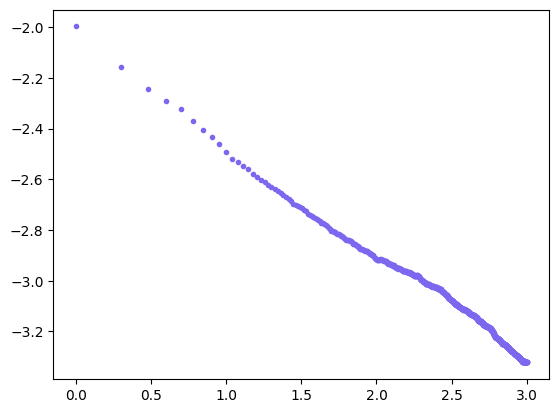

In [10]:
run = True
if run == True:
    export = hockey_plot(folder_name, M, reference)
    print(np.shape(export))
    np.save(os.path.join(file_path, os.path.join(folder_name, f'make_plot')), export)


plot a wavefront 

(699, 4)


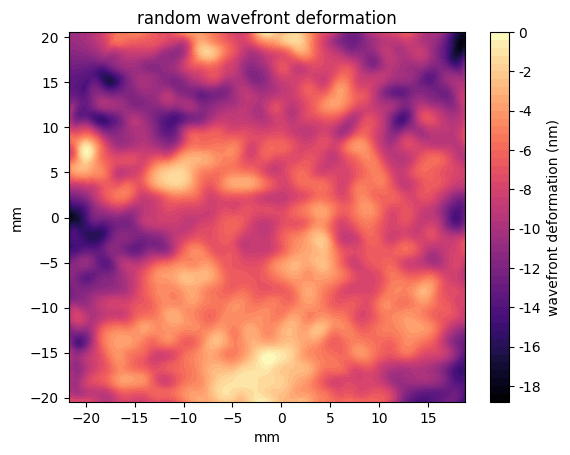

(436, 431)


In [ ]:
# number of live cents set used to find wavefront
i = 900
centroids = np.load(os.path.join(file_path, os.path.join(folder_name, f'centroids{i}.npy')))
        
hsc_ref = HS_Centroids()
hsc_live = HS_Centroids()
hsc_ref.centroids = reference
hsc_live.centroids = centroids

hsg = HS_Gradients(hsc_ref, hsc_live)
hsg.origin = np.array([2047/2,2047/2])
hsg.pixel_size = pixel_size
hsg.magnification = magnification
hsg.construct_gradients()

raw_gradients = hsg.gradients

prism_x = np.mean(raw_gradients[:, 0])
prism_y = np.mean(raw_gradients[:, 1])        

no_prism_gradients = raw_gradients

no_prism_gradients[:, 0] = raw_gradients[:, 0] - prism_x
no_prism_gradients[:, 1] = raw_gradients[:, 1] - prism_y

nice_gradients = remove_nasty_gradients(no_prism_gradients)

plot_gradients = HS_Gradients()
plot_gradients.gradients = nice_gradients
plot_gradients.final_centroids = nice_gradients[:,2:]
print(np.shape(plot_gradients.gradients))

wf_noprism = HSM_WFN.calculate_wf_from_hsgradients(plot_gradients, to_interpolate = False)

# format axes
gspacing = 4 * plot_gradients.pixel_size

limits = {}
limits["x"] = np.array(
     [plot_gradients.gradients[:,2].min() - gspacing, plot_gradients.gradients[:,2].max() + gspacing]
)

limits["y"] = np.array(
    [plot_gradients.gradients[:,3].min() - gspacing, plot_gradients.gradients[:,3].max() + gspacing]
)

xaxis = np.arange(limits["x"][0], limits["x"][1], gspacing) * magnification * 1e3
yaxis = np.arange(limits["y"][0], limits["y"][1], gspacing) * magnification * 1e3

plt.contourf(xaxis, yaxis, -wf_noprism, origin='lower', cmap = plt.cm.magma, levels = 50)

func = lambda x,pos: "{:g}".format(x*1e9)
fmt = matplotlib.ticker.FuncFormatter(func)
cbar = plt.colorbar(format=fmt)
cbar.set_label('wavefront deformation (nm)')

plt.gca().aspect = 'equal'
plt.title(f'random wavefront deformation')
plt.xlabel('mm')
plt.ylabel('mm')
plt.show()

print(np.shape(wf_noprism))

Create plot

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
C:\Users\katel\AppData\Local\Temp\ipykernel_11976\3770915664.py:16: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_ylabel("log10(wavefront difference / $\lambda$)")


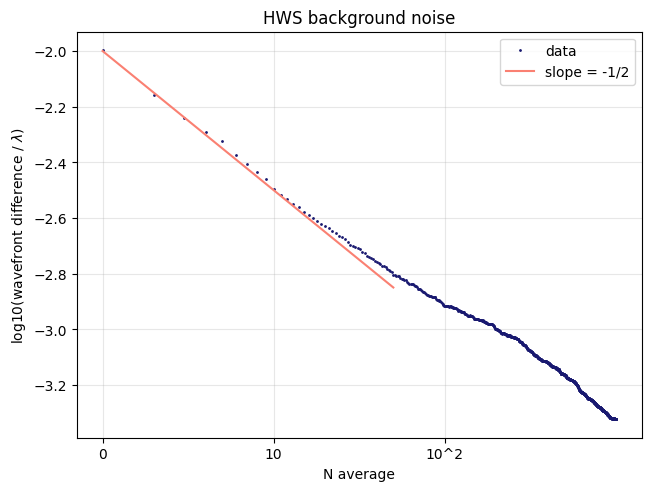

In [ ]:
#create instance of a plot to update 
x = np.arange(M)
line_points = np.arange(50)

fig, ax1 = plt.subplots(layout='constrained')

plot_this_1 = np.load(os.path.join(file_path, os.path.join(folder_name, f'make_plot.npy')))

ax1.plot(np.log10(x + 1), np.log10(plot_this_1), '.', markersize = 2,  color = 'midnightblue', label = 'data')
ax1.plot(np.log10(line_points + 1), -(np.log10(line_points + 1)/2)-2, color = 'salmon', label = 'slope = -1/2')

plt.legend(loc = 'upper right')
plt.title('HWS background noise')
plt.gca().aspect = 'equal'
ax1.set_xlabel('N average')
ax1.set_ylabel("log10(wavefront difference / $\lambda$)")

ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels([0, 10, '10^2'])
ax1.grid(alpha = 0.3)

plt.show()

In [14]:
# find the minimum wavefront deformation which could be observed above the noise floor
# x value of start of noise floor, find from plot above
x_noise = 70
y_noise = plot_this_1[x_noise]
wavefront_deformation = y_noise * wavelength
print('minimum wavefront deformation above noise floor =', wavefront_deformation, 'm')

minimum wavefront deformation above noise floor = 1.1624025819996264e-09 m


linear fit

In [15]:
def line(x, m, c):
    '''equation of a line'''
    y = m*x + c
    return y

In [16]:
# only consider the linear part of the plot
N_linear = 60
x_linear = np.arange(N_linear)
x_linear = x_linear[1:N_linear] #remove zero

xlog = np.log10(x_linear)
ylog = np.log10(plot_this_1[0:N_linear-1])

initial_guess = (0.5, -1.1)

p0, _ = scipy.optimize.curve_fit(line, xlog, ylog, p0 = initial_guess)
m = round(p0[0], 3)
c = round(p0[1], 3)
print(m, c)

-0.46 -2.022


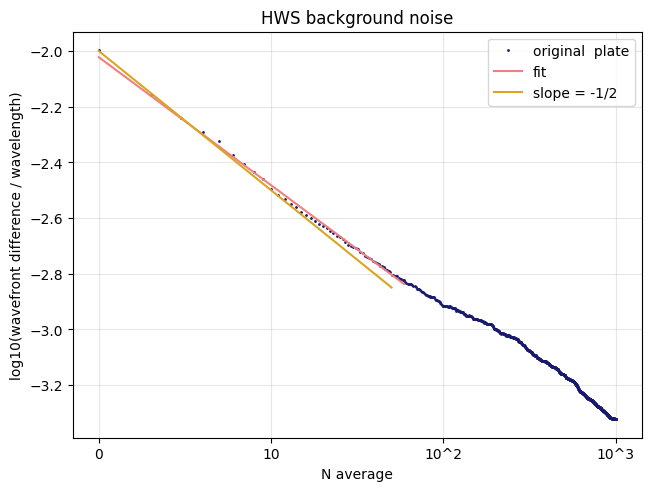

-0.46


In [17]:
x = np.arange(M)

fig, ax1 = plt.subplots(layout='constrained')

ax1.plot(np.log10(x + 1), np.log10(plot_this_1), '.', markersize = 2,  color = 'midnightblue', label = 'original  plate')
ax1.plot(xlog, line(xlog, *p0), color = 'lightcoral', label = 'fit')
ax1.plot(np.log10(line_points + 1), -(np.log10(line_points + 1)/2)-2, color = 'goldenrod', label = 'slope = -1/2')


plt.legend(loc = 'upper right')
plt.title('HWS background noise')
plt.gca().aspect = 'equal'
ax1.set_xlabel('N average')
ax1.set_ylabel('log10(wavefront difference / wavelength)')

ax1.set_xticks([0, 1, 2, 3])
ax1.set_xticklabels([0, 10, '10^2', '10^3'])
ax1.grid(alpha = 0.3)

# ax2 = ax1.twinx()
# ax2.set_ylim(-4.9, -0.83)
# ax2.set_yticks(ticks)
# ax2.set_yticklabels(['wavelength/30', 'wavelength/100', 'wavelength/300', 'wavelength/1000', 'wavelength/3000', 'wavelength/10000', 'wavelength/30000'])

plt.annotate(text = f'y = {m} x + {c}', xy = (0, -4.5))

plt.show()
print(m)

plot temperature over time

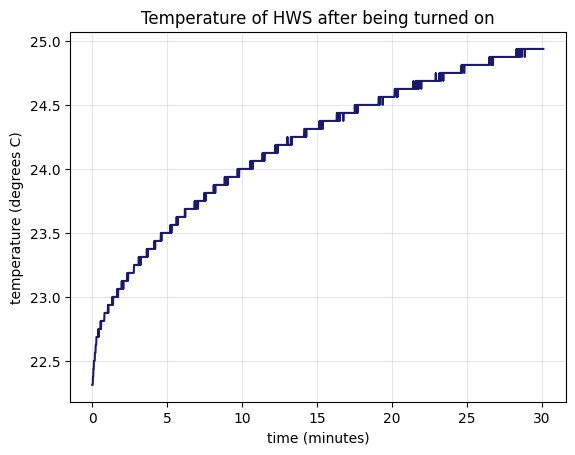

In [18]:
# load data to plot
temp_plot = np.load(os.path.join(file_path, os.path.join(folder_name, f'camera_temperature.npy'))) 

initial_time_1 = temp_plot[0, 0, 0] # time when data recording commenced
seconds_1 = temp_plot[0, 0, :] - initial_time_1 # rescale x axis so time zero is when data recording began
degrees_1 = temp_plot[1, 0, :] # the temperature

# fig, ax1 = plt.subplots(2, 1, layout='constrained', figsize = (6, 8))

# plt.subplot(2, 1, 1)
plt.plot(seconds_1 / 60, degrees_1, color = 'midnightblue')
plt.title('Temperature of HWS after being turned on')
plt.xlabel('time (minutes)')
plt.ylabel('temperature (degrees C)')
plt.grid(alpha = 0.3)

# plt.subplot(2, 1, 2)
# # plot x axis as log scale
# plt.semilogx(seconds_1, degrees_1, color = 'midnightblue')
# plt.xlabel('log(time) (s)')
# plt.ylabel('temperature (degrees C)')

plt.show()